# Week 3: Floating-Rate Notes


## FINM 37400: Fixed Income

### Mark Hendricks

#### Winter 2024

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from utils import *

$\newcommand{\value}{V}$
$\newcommand{\price}{P}$
$\newcommand{\float}{\text{float}}$
$\newcommand{\freq}{\kappa}$
$\newcommand{\tbond}{\text{fixed}}$
$\newcommand{\cpn}{c}$
$\newcommand{\spread}{s}$
$\newcommand{\swap}{\text{swap}}$
$\newcommand{\swaprate}{\cpn_{\swap}}$
$\newcommand{\cashflow}{C}$
$\newcommand{\notional}{K}$

# Floating-Rate Notes

### Definition
A **floating rate bond**--or Floating Rate Note (FRN)--pays a coupon based on a particular variable short-term interest rate, $r$, as well as a pre-specified spread, $s$.

Suppose that 
- the compounding frequency of the rate is $\freq$, denoted $r_\freq(t,T)$. 
- the coupon frequency is also $\freq$.
- the spread $s$ is with respect to rates of frequency $\freq$

### Example: Goldman Corp FRN

<img src="../refs/floater_gs_info.png"/>
<img src="../refs/floater_gs_coupons.png"/>

## Floating Rate Formula

**The floating-rate coupon is (annualized)**
$\begin{align}
\cpn(T_i) = 100 (r(T_{i-1},T_i) + s)
\end{align}$

Note that
- This coupon is annualized, so the payment is $\cpn(T_i)/\freq$, similar to how the vanilla treasury coupon was divided by 2.
- This coupon is based on the **rate in arrears**. Thus the coupon at $T_i$ depends on the rate at $T_{i-1}$.
- The spread, $s$, is fixed over the life of the bond. The coupon only "floats" due to $r$, not $s$.
- The bond pays face value at maturity, $T$.

### Timing
The dates $T_i$, for $i=0\ldots n$ are known as the **reset dates**. 
- $T_0 = 0$
- $T_n = T$
- $n$ is the number of coupon payments.
- Given maturity $T$ and frequency $\freq$, we have $n=\freq T$

On these dates,
- the bond pays a coupon.
- the following floating rate is set

At the boundaries,
- $T_0=0$, the floating rate for $T_1$ is set, though no coupon is paid.
- $T_n=T$, the final coupon (and face value) is paid, and the bond is retired.

## Floating Rate Coupons and Yields

### Bloomberg FRN Total Return Index

<img src="../refs/bloomberg_frn_index.png"/>

The plots below display data on FRN indexes.
- **Yields**. Average yield of issues included in the index. Specifically, the yield used is the **yield-to-worst** which is the lower yield of **yield-to-maturity** and **yield-to-call**, (the latter accounts for the fact that many corporate FRN have an attached call option.

- **Coupons**. The average coupon of issues included in the index.

- **Fed Funds**. The Fed Funds Effective Rate used as a benchmark reference (risk-free) floating rate.

### Floating rates

Yields
* the FRN yield moves closely with the reference rate (represented here with Tbill rates)
* the corporate yield on FRN is typically lower than on fixed,but not always
* the FRN yield on Treasuries is lower than on Corporates

Coupons
* Corporate floater coupon is higher than Treasury floaters due to a spread
* Treasury floating coupons track the Tbill rate closely (since launched in 2014.)

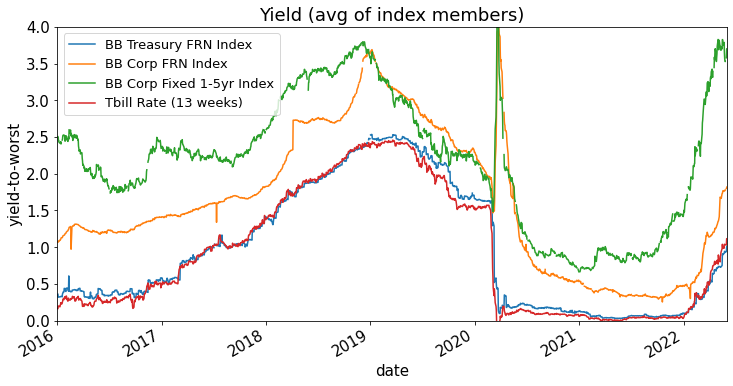

In [2]:
filepath_INDEX = '../data/index_floaters.xlsx'
ylds = pd.read_excel(filepath_INDEX,sheet_name='yields').set_index('Unnamed: 0')
ylds.index.name = 'date'
ylds.iloc[:,:].plot(ylabel='yield-to-worst',xlim=('2016-01-01','2022-06-01'),ylim=(0,4),title='Yield (avg of index members)')
plt.show()

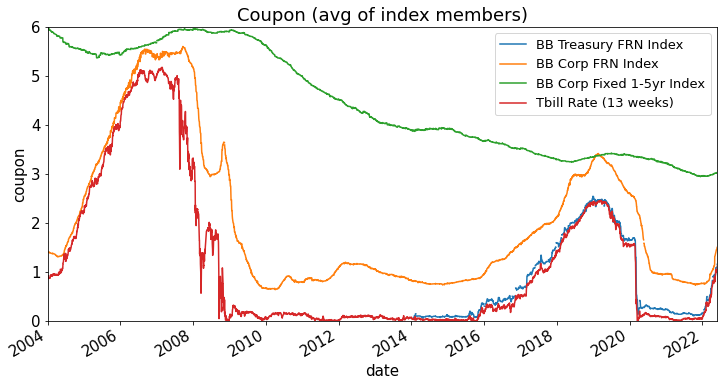

In [3]:
coupons = pd.read_excel(filepath_INDEX,sheet_name='coupons').set_index('Unnamed: 0')
coupons.index.name = 'date'
coupons.plot(ylabel='coupon',xlim=('2004-01-01','2022-06-01'),ylim=(0,6),title='Coupon (avg of index members)')
plt.show()

# Fixed vs Floating

1. Floating-rate notes outperform fixed-rate notes in periods of rising rates.
2. Floating-rate notes underperform fixed-rate notes in falling rates.
3. Floating-rate notes have much less volatile returns than fixed-rated notes.

The figures below illustrate these facts.
* Left y-axis: total returns
* Right y-axis: T-bill rate

In [4]:
filepath_INDEX = '../data/index_floaters.xlsx'
prices = pd.read_excel(filepath_INDEX,sheet_name='prices').set_index('Unnamed: 0')
prices.index.name = 'date'

In [5]:
def plot_float_vs_fix(prices,view0,view1,ylim=None, desc=None):

    prices_sub = prices.div(prices.loc[view0,:])

    fig, ax1 = plt.subplots()
    prices_sub.plot(ax=ax1,xlim=(view0,view1),ylim=ylim,title=desc,ylabel='total return index')

    ax2 = ax1.twinx()
    ylds.iloc[:,-1].plot(ax=ax2, xlim=(view_date0,view_date1),ylabel='rate',color='k')
    
    plt.legend([ylds.columns[-1]])
    
    return fig

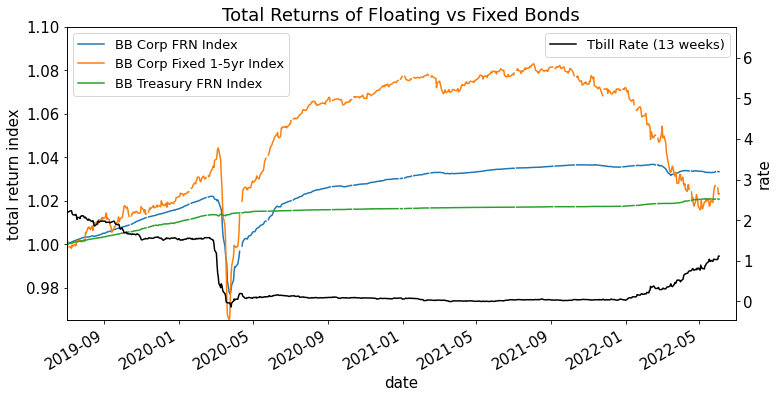

In [6]:
view_date0 = '2019-07-01'
view_date1 = '2022-06-30'

prices_sub = prices.iloc[:,[1,2,0]]

plot_float_vs_fix(prices_sub,view_date0,view_date1,ylim=(.965,1.1),desc='Total Returns of Floating vs Fixed Bonds')
plt.show()

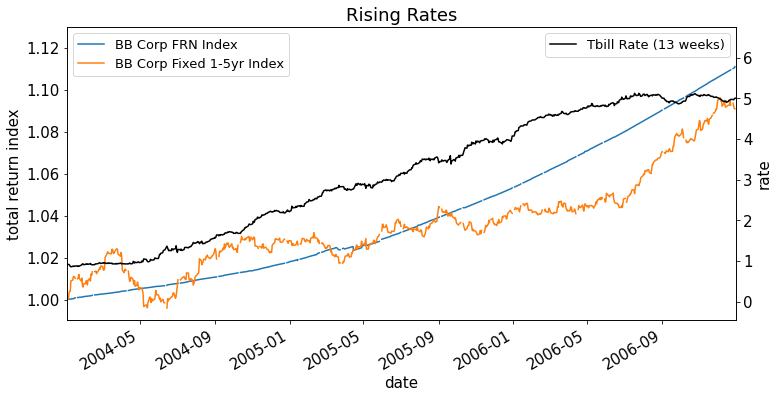

In [7]:
view_date0 = '2004-01-02'
view_date1 = '2006-12-31'

prices_sub = prices.iloc[:,1:]
plot_float_vs_fix(prices_sub,view_date0,view_date1,ylim=(.99,1.13),desc='Rising Rates')
plt.show()

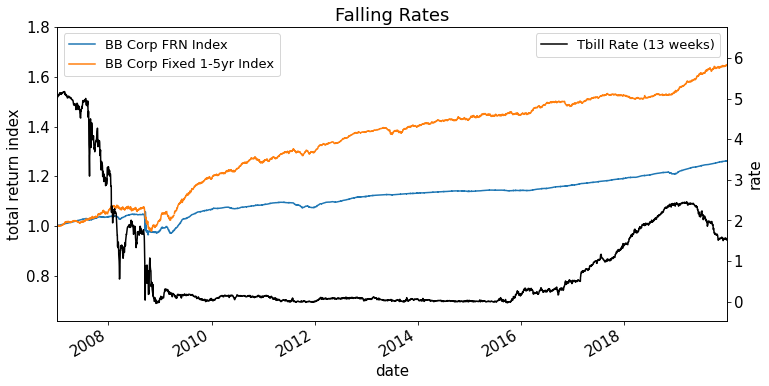

In [8]:
view_date0 = '2007-01-02'
view_date1 = '2019-12-31'

prices_sub = prices.iloc[:,1:]
plot_float_vs_fix(prices_sub,view_date0,view_date1,desc='Falling Rates')
plt.show()

# Valuation

## Valuation at reset dates

### Price Notation

Denote the price of a floater as

$\price_{\float}(t,T;s)$

- a function of the current time, $t$, as well as the spread, $s$. 
- For notational simplicity, the other arguments, including reset dates and underlying reference rate, are not notated explicitly.

### Par Value
Suppose that...
- reset dates and coupon dates both occur with frequency $\freq$.
- the floating rate is the risk-free rate associated with the discount curve, $r_\freq(T_{i-1},T_i)$, where the subscript $\freq$ denotes the compounding frequency
- there is no spread, $s=0$.

**The price of the floater with zero spread at reset date $T_i$ equals its face value.**

$\price_{\float}(T_i,T;0) = 100$

- This is the **ex-coupon** price, so the above equation indicates the price immediately after any $T_i$ coupon is paid.

### The discount rate and (floating) coupon rate are exactly offsetting!

If the rate rises, 
- this increases the coupon, 
- but it also increases the discount rate on the cashflow.
- the effects exactly offset in this model.

## Example: U.S. Treasury FRNs

Since 2014, the U.S. Treasury has issued floating-rate Treasury bonds.
- Maturity: 2 years
- Underlying rate: 13-week T-bill
- Spread: set such that bond issues at par.
- Coupon Frequency: quarterly

[Treasury FRNs](https://www.treasurydirect.gov/indiv/products/prod_frns_glance.html) are a niche offering--less than 1% of outstanding treasury debt.

**Across multiple issues and since 2016, price has varied less than 0.5\% from face value!**

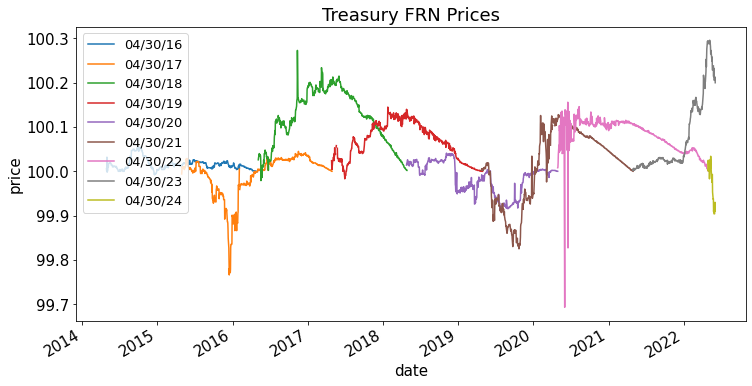

In [9]:
filepath_TFRN = '../data/treasury_floaters.xlsx'
raw = pd.read_excel(filepath_TFRN,sheet_name='data').set_index('Unnamed: 0')
raw.index.name = 'date'
raw.plot(title='Treasury FRN Prices',ylabel='price')
plt.show()

The Treasury FRN differ from our assumptions above, but the price is still near par.

Most notably, these Treasury FRNs have spreads--but they are very small.

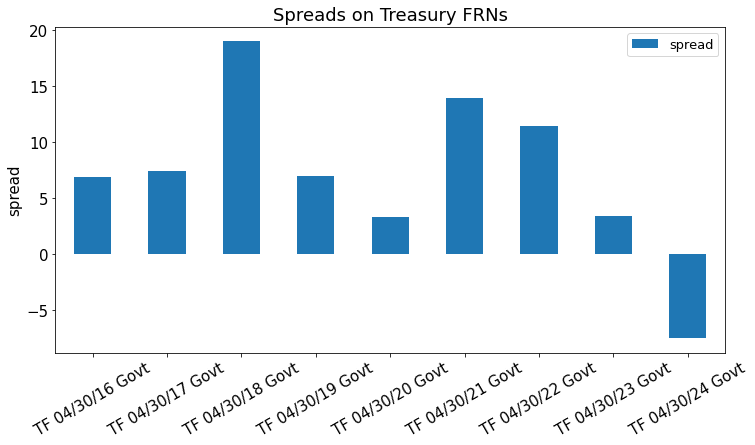

In [10]:
raw = pd.read_excel(filepath_TFRN,sheet_name='specs').set_index('Unnamed: 0')
raw.index.name=''
raw.rename(columns={'flt_spread':'spread'},inplace=True)
raw[['spread']].plot.bar(ylabel='spread',title='Spreads on Treasury FRNs')
plt.xticks(rotation=30)
plt.show()

# Valuation with a spread

If the spread is non-zero, 
* price will not necessarily stay near par
* corporate bonds typically are set up close to the model above, with a spread

### Example: Corporate FRNs

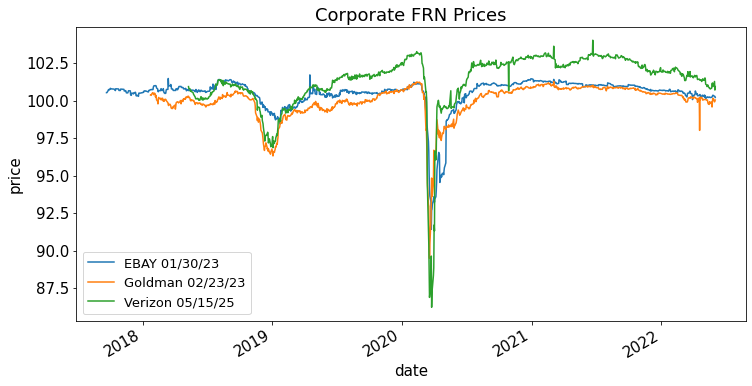

In [11]:
filepath_CFRN = '../data/corp_floaters.xlsx'
raw = pd.read_excel(filepath_CFRN,sheet_name='data').set_index('Unnamed: 0')
raw.index.name = 'date'
raw.plot(title='Corporate FRN Prices',ylabel='price')
plt.show()

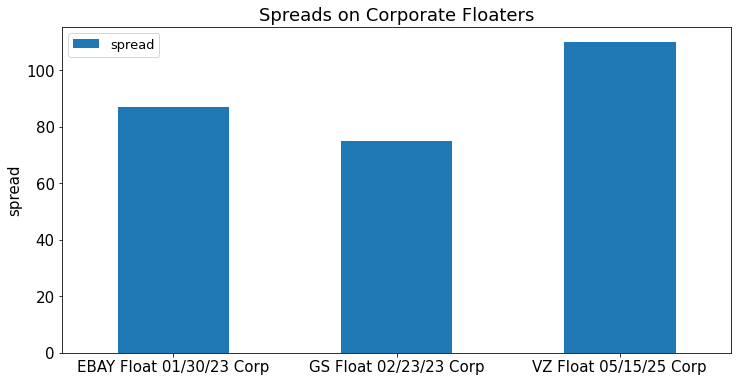

In [12]:
raw = pd.read_excel(filepath_CFRN,sheet_name='specs').set_index('Unnamed: 0')
raw.index.name=''
raw.rename(columns={'flt_spread':'spread'},inplace=True)
raw[['spread']].plot.bar(ylabel='spread',title='Spreads on Corporate Floaters')
plt.xticks(rotation = 0) 
plt.show()

## Caution: Valuation with frictions

Our model above relied on the following assumptions:
- the floating rate corresponds to the risk-free rate
- the coupon is based on the floating rate in arrears
- the floating rate is based on compounding frequency equal to the coupon frequency

Without these assumptions, we do not obtain the result that price is par on reset dates.

### Nonetheless...

* prices of Treasury FRN trade very close to par.
* the models above are the dominant baseline for pricing.

## Revisiting the Example: U.S. Treasury FRNs

Above we looked at U.S. Treasury FRNs. However,

**Treasury FRNs violate several of our simple assumptions**

1. Coupon frequency differs from reset date frequency.
    - Coupons are quarterly.
    - Resets are weekly

2. Underlying rate is not the same as the discount rate
    - 13 week treasury bill rate (annualized) averaged arithmetically
    
Still, they price near par as the baseline model would suggest.

These complications have a minor impact on price.

### Treasury FRN Contract

<img src="../refs/treasury_frn_contract.png"/>

### Questions for consideration

1. Does the Treasury FRN having a more frequent reset than its coupon (weekly vs quarterly) increase or decrease its duration?
1. The mathematical modeling above showed that FRNs trade at par on reset dates. Then why does the Treasury need to include a potential spread, $s$, in order to get the price to par at issuance?

# Appendix

## Details Valuation 
### Explanation via Backward Induction

This is easiest to see via backward induction. 

Consider the value at the final reset date, $T_{n-1}$.

$\begin{align}
\price_{\float}(T_{n-1}) =& 100 \left[c(T_n)/\freq + 1\right]Z(T_{n-1},T_n)\\
=& 100\left[r_\freq(T_{n-1},T_n)/\freq+1\right]Z(T_{n-1},T_n)\\
=& 100\frac{1+r_\freq(T_{n-1},T_n)/\freq}{1+r_\freq(T_{n-1},T_n)/\freq}\\
=& 100
\end{align}$

Now, write the value at the preceding reset date as the discounted coupon plus the ex-coupon price just calculated,

$\begin{align}
\price_{\float}(T_{n-2}) =& \left[100\, c(T_{n-1})/\freq + \price_{\float}(T_{n-1})\right]Z(T_{n-2},T_{n-1})\\
=& 100 \left[c(T_{n-1})/\freq + 1\right]Z(T_{n-2},T_{n-1})\\
=& 100
\end{align}$

Iterating back, we find that for reset (and coupon) dates, $T_i$, the floating-rate bond's price is par:

$\price_{\float}(T_i) = 100$

## Details: Valuation between resets

We can easily extend to get the price at any date $t$, such that $t$ is between reset dates

$T_{j-1} < t < T_j$

$\begin{align}
\price_{\float}(t) =& Z(t,T_j)\left[\price_{\float}(T_j) + 100\, \frac{\cpn(T_j)}{2}\right]\\
=& 100\, Z(t,T_j)\left[1 + \frac{r_{\freq}(T_{j-1},T_j)}{2}\right]
\end{align}$

## Details: Pricing the floater with spread:

**Decompose the floater into a zero-spread floater and fixed-rate bonds.**

Note that the coupon is replicated with the combination of 
- a floating bond with zero spread
- a vanilla bond with coupon $s$
- short a vanilla bond with zero-coupon

Let $\price_{\tbond}(t,T;\spread)$ denote the price of a fixed-coupon Treasury with 
- coupon equal to $\spread$ 
- coupons on the same date as the floating-rate bond.

$\begin{align}
\price_{\float}(t,T;\spread) =& \price_{\float}(t,T;0) + \price_{\tbond}(t,T;\spread) - \price_{\tbond}(t,T;0)\\
\end{align}$

#### At reset dates
Consider the price at $t=0$, where the floating rate bond is par:

$\begin{align}
\price_{\float}(0,T;\spread) =& 100 + 100\,\spread\,\sum_{i=1}^nZ(0,T_i)\\
=& 100\left[1 + \spread\,\sum_{i=1}^nZ(0,T_i)\right]
\end{align}$

#### At interim dates

At interim date, $t$, one simply adjusts by discounting the expression above to the next reset / coupon date, along with adding the discounted floating rate coupon for the first date.

Consider the price at an interim date $T_{j-1} < t < T_j$:

$\begin{align}
\price_{\float}(t,T;\spread) =& 100\left[\underbrace{r_\freq(T_{j-1},T_j) + \spread}_{\text{next floating coupon}} + \underbrace{1 + s\,\sum_{i=1}^nZ(t,T_i)}_{\text{value at reset}}\right]\underbrace{Z(t,T_j)}_{\text{discount to next reset}}
\end{align}$